In [351]:
#coding:utf8
import pandas as pd 
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
from tensorflow import keras

from tensorflow.keras import layers, metrics
from sklearn.ensemble import RandomForestRegressor

In [352]:
def load_data(em_data = True, veh_data = True, air_data = True):
    args = []
    if em_data:
        EU_em_df = pd.read_excel('Data/EU_em.xlsx',engine='openpyxl')
        EU_em_annual_df = pd.read_csv('Data/EU_em_annual.csv',)
        UK_em_df = pd.read_excel('Data/UK_em.ods', nrows = 14)
        US_em_df = pd.read_excel('Data/US_em.xlsx',engine='openpyxl')
        # Emissions data Processing
        EU_em_df = EU_em_df.set_index('Month')
        EU_em_annual_df = EU_em_df.groupby(np.arange(len(EU_em_df))//(12)).sum()
        EU_em_annual_df.index = np.linspace(1973, 2021, EU_em_annual_df.shape[0], dtype=np.int32)
        UK_em_df = UK_em_df.transpose()
        UK_em_df.columns = UK_em_df.iloc[0, :]
        UK_em_df = UK_em_df.drop('Year')
        US_em_df = US_em_df.transpose()
        US_em_df.columns = US_em_df.iloc[0, :]
        US_em_df = US_em_df.replace('+', 0)
        US_em_df = US_em_df.drop('Year')
        args += [EU_em_df, EU_em_annual_df, UK_em_df, US_em_df]
    if veh_data:
        EU_veh_df = pd.read_csv('Data/EU_veh.csv')
        UK_veh_df = pd.read_excel('Data/UK_veh.ods', nrows= 27)
        US_veh_df = pd.read_excel('Data/US_veh.xlsx', nrows = 9)
        US_veh_df = US_veh_df.transpose()
        US_veh_df.columns = US_veh_df.iloc[0, :]
        US_veh_df = US_veh_df.drop('Model Year')
        args += [EU_veh_df, UK_veh_df, US_veh_df]
    if air_data:
        # Secondary Data 
        # Air pollution
        # UK 1970-2019/2022
        UK_nox_annual_df = pd.read_csv('Data/Figure06_NOx_time_series.csv')
        UK_pm_all_annual_df = pd.read_csv('Data/Figure03_PM_time_series.csv')
                
        # USA Since 1970-2020, plz Access through column id(numbers)
        USA_nox_annual_df = pd.read_csv('Data/US_nox_em_time_series.csv') # National Emissions Totals (thousands of tons)
        USA_pm_10_annual_df = pd.read_csv('Data/US_pm10_year.csv')        #
        USA_pm_2_5_annual_df = pd.read_csv('Data/US_pm2_5_year.csv')
        
        USA_pm_2_5_annual_df = USA_pm_2_5_annual_df.transpose()
        USA_pm_10_annual_df = USA_pm_10_annual_df.transpose()
                
        # OCED DATA
        OCED_PM10_df = pd.read_excel('Data/PM10_ROAD_OCED_WORLD_DATA.xlsx')
        OCED_NOX_df = pd.read_excel('Data/NOX_ROAD_OCED_WORLD_DATA.xlsx')
        OCED_PM2_5_df = pd.read_excel('Data/PM2_5_ROAD_OCED_WORLD_DATA.xlsx')
    
    args += [UK_nox_annual_df,UK_pm_all_annual_df,USA_pm_10_annual_df,USA_pm_2_5_annual_df,USA_nox_annual_df,OCED_PM10_df,OCED_NOX_df,OCED_PM2_5_df]
        
    return args

def process_data(X, y):
    X_norm, X_attrs, y_norm, y_attrs = normalise(X, y)
    y_norm = np.roll(y_norm, -time_step)
    nrows = X_norm.shape[0]
    samples = X_norm.shape[1]
    X_norm = np.repeat(X_norm, data_memory, 0).reshape(nrows, data_memory, samples)
    split_point = int(X_norm.shape[0] *0.75)
    x_train, x_test, y_train, y_test = train_test_split(X_norm, y_norm, split_point)
    return x_train, x_test, y_train, y_test, nrows, samples, X_norm, y_norm, X_attrs, y_attrs

def normalise(X, y):
    X_attrs = np.zeros((X.shape[-1], 2))
    y_attrs = np.zeros((y.shape[-1], 2))
    for i in range(X.shape[-1]):
        X_attrs[i, :] = [np.mean(X[:, i]), np.var(X[:, i])]
        X[:, i] = (X[:, i] - np.mean(X[:, i]))/np.var(X[:, i])**0.5
    for i in range(y.shape[-1]):
        y_attrs[i, :] = [np.mean(y[:, i]), np.var(y[:, i])]
        y[:, i] = (y[:, i] - np.mean(y[:, i]))/np.var(y[:, i])**0.5  
    return X, X_attrs, y, y_attrs

def train_test_split(X, y, split_point):
    x_train = X[:split_point, :, :]
    x_test = X[split_point:, :, :]
    y_train = y[:split_point]
    y_test = y[split_point:]
    return x_train, x_test, y_train, y_test
        
def create_model(layers, input_shape, print_summary):
    model = keras.Sequential(layers)
    model.build(input_shape=input_shape)
    model.compile(loss='mse', optimizer='adam')
    if print_summary:
        model.summary()
    return model

def plot_pred(y, y_pred, plot_range):
    t = np.linspace(plot_range[0], plot_range[1], plot_range[1] - plot_range[0])
    plt.plot(t, y[plot_range[0] : plot_range[1]], 'g', t, y_pred[plot_range[0]: plot_range[1]], 'r')

def run_model(X, y, data_memory, epochs, batch_size, model_des, plot_pred_bool, plot_range, print_summary):
    x_train, x_test, y_train, y_test, nrows, samples, X_norm, y_norm, X_attrs, y_attrs = process_data(X, y)
    input_shape = (x_train.shape[0], data_memory, samples)
    model = create_model(model_layer, input_shape, print_summary)
    history = model.fit(x_train, y_train, validation_split = 0.1, epochs= epochs , batch_size=batch_size)
    y_pred_norm = np.concatenate((model.predict(x_train[:, :, :]), model.predict(x_test[:, :, :])))
    mse = metrics.MeanSquaredError()
    mse.update_state(y_norm, y_pred_norm)
    test_loss = mse.result().numpy()
    print(y_attrs)
    y_pred = np.roll(y_pred_norm /y_attrs[:, 1]**0.5 + y_attrs[:, 0] , -time_step)
    print(test_loss)
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    model_performance = [time_step, data_memory, samples, model_des, epochs, batch_size, train_loss, val_loss, test_loss]
    df_model = pd.DataFrame(model_performance).transpose()
    df_model.columns = df_model_columns
    df_model.to_csv('model_performance.csv', mode = 'a', header= False)
    if plot_pred_bool:
        plot_pred(y, y_pred, plot_range)
    return y, y_pred


In [353]:
args = load_data()
EU_em_df, EU_em_annual_df, UK_em_df, US_em_df, EU_veh_df, UK_veh_df, US_veh_df, UK_nox_annual_df,UK_pm_all_annual_df,USA_pm_10_annual_df,USA_pm_2_5_annual_df,USA_nox_annual_df,OCED_PM10_df,OCED_NOX_df,OCED_PM2_5_df = args

C:\Apps\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [354]:
time_step = 1
data_memory = 5
epochs = 20
batch_size = 1
df_model_columns =  ['time_step', 'data_memory', 'samples', 'layers', 'epochs', 'batch_size', 'training_loss', 'val_loss', 'test_loss']
model_des = 'D32, GRU32, GRU32 D1'
model_layer = [layers.Dense(32, activation= 'sigmoid'),
                layers.GRU(32,activation= 'softsign', recurrent_activation = 'relu', recurrent_dropout = 0.1, dropout = 0.1),
                layers.Dense(1)]
# sigmoid, softsign, relu 
# activation='softsign', recurrent_activation='relu'
plot_range = [0]
plot_range += [plot_range[0] + 30]
plot_pred_bool = False  
print_summary = False
#model_df = pd.DataFrame(model_performance).transpose()
#model_df.to_csv('model_performance.csv')
EU_em_X, EU_em_y = np.split(EU_em_df.to_numpy(), [11], 1)
UK_em_X, UK_em_y = np.split(UK_em_df.to_numpy(dtype=np.float64), [13], 1)
US_em_X, US_em_y, a = np.split(US_em_df.to_numpy(dtype=np.float64), [45,46], 1)
EU_veh_X = EU_veh_df.to_numpy()
UK_veh_X = UK_veh_df.to_numpy(dtype=np.float64)
US_veh_X, US_veh_y = np.split(US_veh_df.to_numpy(dtype=np.float64), [8], 1)


In [355]:
y, y_pred = run_model(US_em_X[:, :15], US_em_y, data_memory, epochs, batch_size, model_des, plot_pred_bool, plot_range, print_summary)

Epoch 1/20
19/19 [==============================] - 3s 35ms/step - loss: 1.1012 - val_loss: 0.3422
Epoch 2/20
19/19 [==============================] - 0s 6ms/step - loss: 0.7304 - val_loss: 0.2762
Epoch 3/20
19/19 [==============================] - 0s 6ms/step - loss: 0.3845 - val_loss: 0.8647
Epoch 4/20
19/19 [==============================] - 0s 6ms/step - loss: 0.2127 - val_loss: 1.0917
Epoch 5/20
19/19 [==============================] - 0s 6ms/step - loss: 0.1881 - val_loss: 0.1593
Epoch 6/20
19/19 [==============================] - 0s 6ms/step - loss: 0.0560 - val_loss: 0.1209
Epoch 7/20
19/19 [==============================] - 0s 6ms/step - loss: 0.1558 - val_loss: 0.5844
Epoch 8/20
19/19 [==============================] - 0s 6ms/step - loss: 0.1031 - val_loss: 0.5014
Epoch 9/20
19/19 [==============================] - 0s 5ms/step - loss: 0.1182 - val_loss: 0.4755
Epoch 10/20
19/19 [==============================] - 0s 5ms/step - loss: 0.0958 - val_loss: 0.1363
Epoch 11/20
19/19 

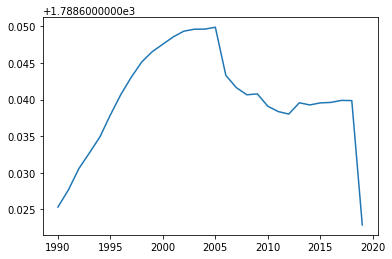

In [356]:
t = np.linspace(1990, 2019, 30)
plt.plot(t, y_pred)

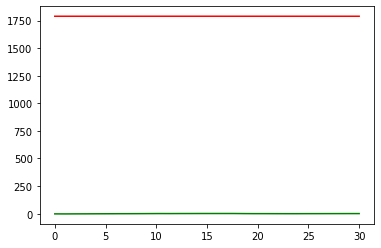

In [357]:
plot_pred(US_em_y, y_pred, plot_range)

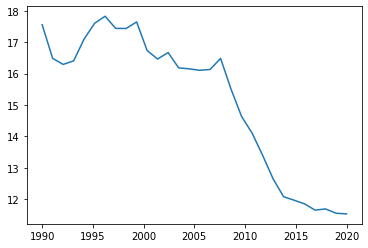

In [358]:
UK_em_df.shape
t = np.linspace(1990, 2020, 30, endpoint=True)
plt.plot(t, UK_em_X[:, -2])

In [359]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int("dense_units", min_value=16, max_value=128, step=16)))
    model.add(layers.GRU(units=hp.Int("GRU_units", min_value=16, max_value=128, step=16), activation='sigmoid', recurrent_activation='sigmoid'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss = 'mse')
    return model
val_split = int(x_train.shape[0] * 0.9)
x_train_val, x_val, y_train_val, y_val = train_test_split(x_train, y_train, val_split)
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="RNN_em",
    project_name="RNN_em",
    )

tuner.search(x_train, y_train, epochs=2, validation_data=(x_val, y_val))
models = tuner.get_best_models(num_models=2)
best_model = models[0]
input_shape = (x_train.shape[0], data_memory, samples)
best_model.build(input_shape=input_shape)
best_model.summary()
tuner.results_summary()
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])
history = model.fit(x=x_train, y=y_train, epochs=10)

Trial 3 Complete [00h 00m 07s]
val_loss: 0.1846400871872902

Best val_loss So Far: 0.1846400871872902
Total elapsed time: 00h 00m 25s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (439, 5, 64)              768       
                                                                 
 gru (GRU)                   (439, 80)                 35040     
                                                                 
 dense_1 (Dense)             (439, 1)                  81        
                                                                 
Total params: 35,889
Trainable params: 35,889
Non-trainable params: 0
_________________________________________________________________
Results summary
Results in RNN_em\RNN_em
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
dense

ValueError: x and y must have same first dimension, but have shapes (20,) and (0, 1)

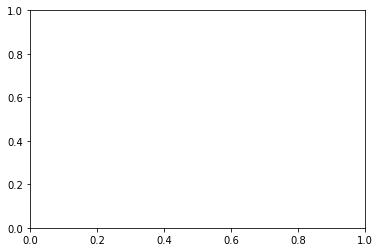

In [360]:
plot_range = [80]
plot_range += [plot_range[0] + 20]
t = np.linspace(plot_range[0], plot_range[1], plot_range[1] - plot_range[0])
plt.plot(t, y[plot_range[0] : plot_range[1]], 'g', t, y_pred[plot_range[0]: plot_range[1]], 'r')